# [모듈 3.1] TensorFlow 를 위한 이미지 전처리
Download | Structure | **Preprocessing (TensorFlow)** | Train Model (TensorFlow) (4단계 중의 3/4)

### [알림] <font coler="red"> conda_tensorflow2_p36 커널 </font> 과 함께 사용해야 합니다.

* 이 노트북은 `1.1.download_data` 및 `1.2.structuring_data`로 시작하는 일련의 노트북의 일부입니다. 여기부터는 TensorFlow에 대한 SageMaker의 지원에 중점을 둘 것입니다. 이 시리즈의 다음 노트북은 '3.2.tensorflow_training'입니다.


# 노트북 요약
---

- 이 노트북에서는 TensorFlow 프레임워크 훈련을 ​​위한 크기 조정 및 데이터 증강 변환을 생성합니다. 
- 또한 가장 효율적인 훈련을 위해 데이터를 TensorFlow의 TFRecord 형식으로 변환합니다.


# 0. 환경 설정
___
TensorFlow를 2.3.1로 업데이트하고 TensorFlow Datasets를 설치합니다.


In [1]:
import sys
original_sagemaker_version = !conda list | grep -E "sagemaker\s" | awk '{print $2}'
original_tensorflow_version = !conda list | grep -E "tensorflow\s" | awk '{print $2}'

In [2]:
# !{sys.executable} -m pip install -q "sagemaker==2.9.2" "tensorflow-serving-api==2.3.0" "tensorflow==2.3.1" "tensorflow-datasets==3.2.1"
!{sys.executable} -m pip install -q "sagemaker==2.9.2" "tensorflow-serving-api==2.3.0" "tensorflow==2.3.1" "tensorflow-datasets==3.2.1"
# !{sys.executable} -m pip install -q   "tensorflow-datasets==3.2.1"

In [3]:
import uuid
import pickle
import numpy as np
import sagemaker
import boto3
from tqdm import tqdm
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [4]:
print(f"sagemaker  updated  {original_sagemaker_version[0]} -> {sagemaker.__version__}")
print(f"tensorflow updated  {original_tensorflow_version[0]} -> {tf.__version__}")

sagemaker  updated  2.9.2 -> 2.9.2
tensorflow updated  2.3.1 -> 2.3.1



# 1. TensorFlow Datasets 을 사용하여 데이터 세트 로딩
___
- TensorFlow Datasets는 데이터 세트 및 각 레코드에 대한 래퍼를 생성하여 TensorFlow 및 Keras에서 사용할 데이터를 준비하는 데 유용한 모듈입니다. 
- 이 래퍼에는 분할, 배치 크기, 프리페치, 데이터 변환 및 증강을 쉽게 제어할 수 있는 함수가 있습니다. 
- TensorFlow Datasets는 이미 구조화되고 주석이 달린 인터넷에서 많은 외부 데이터 세트를 가져올 수도 있습니다. 그러나 이 가이드에서는 데이터 세트가 처음부터 완벽하게 구성되지 않았다고 가정하고, 구성하는 것을 배웁니다.

#### 참고
- TensorFlow Datasets 공식 페이지 --> [TensorFlow Datasets](https://www.tensorflow.org/datasets/overview)

## ImageFolder builder 생성

tfds.ImageFolder는 이전에 생성한 공통 폴더 구조에서 이미지 데이터를 읽기 위해 미리 만들어진 빌더입니다.

- 참조: [tfds.folder_dataset.ImageFolder](https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder)

In [5]:
image_folder = tfds.ImageFolder("./data_structured")
image_folder.info

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=11),
    }),
    total_num_examples=2750,
    splits={
        'test': 275,
        'train': 2200,
        'val': 275,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)

이제 이미지 데이터가 카탈로그화 되었으므로 훈련 및 검증을 위한 TensorFlow 데이터 세트를 생성할 수 있습니다. 이러한 데이터 세트는 TensorFlow 또는 Keras와 함께 처리, 증강 및 훈련에 사용할 수 있어 매우 유연합니다.

# 2. TensorFlow 크기 조정 및 증강 (Augmentation)
___

- 이 단계에서는 훈련 및 검증을 위해 별도의 데이터 세트를 생성한 다음 알고리즘이 데이터를 훈련하기 전에 필요한 변환을 정의합니다. 
- 우리는 또한 우리가 가지고 있는 데이터를 최대한 활용하고 모델 훈련 효과를 향상시킬 수 있는 이미지 증강을 정의할 것입니다.

## 훈련 데이터세트 생성
`.as_dataset()` 메소드는 훈련 알고리즘에 필요한 `(image, label)` 튜플을 생성하는 편리한 방법입니다.
* split - 이 데이터세트에 대한 데이터 분할을 지정합니다. (예: train, val, test)
* shuffle_files - 파일 순서 혼합
* as_supervised - (이미지, 레이블) 튜플만 유지하고 모든 메타데이터는 버립니다.

train 데이터만을 포함한 tf.data.Dataset 오브젝트를 생성합니다.

In [6]:
tf.random.set_seed(100)

In [7]:
train_ds = image_folder.as_dataset(split=["train"], shuffle_files=True, as_supervised=True)[0]


100개의 레코드를 선택하고, 첫번째 레코드의 이미지 Shape 과 레이블 값을 확인 합니다.

In [8]:
sample_ds = train_ds.take(100).as_numpy_iterator()
image , label = next(sample_ds)
print(f"image shape: {image.shape}, label: {label}")

image shape: (32, 32, 3), label: 6


## 크기 조정 변환 정의

- 훈련을 위해 GPU로 이동하기 전에 모든 이미지 데이터의 길이, 너비 및 채널 차원이 동일해야 합니다. 
    - 일반적으로 알고리즘은 정사각형 형식을 사용하므로 길이와 너비가 동일하고, 미리 만들어진 많은 데이터 세트에는 이미지가 정사각형으로 잘 잘려져 있습니다.


- 그러나 현업에서는 실제 데이터 세트는 다양한 차원과 비율의 이미지로 존재합니다. 훈련을 위해 데이터 세트를 준비하려면 이미지가 정사각형이 아닌 경우 크기를 조정하고 잘라야 합니다.



- 이미지가 찌그러지거나 늘어나는 것을 방지하려면  <font color="red">이미지를 정사각형으로 *그리고* 이미지의 중요한 개체가 잘리지 않도록 해야 합니다.</font>
    - 불행히도 정사각형이 최적인지 확인하는 쉬운 방법은 없으므로 일반적으로 대부분에 잘 작동하는 정사각형을 선택하고 자릅니다.

In [9]:
def resize(image, label):
    image = tf.image.resize(image, (400, 400), preserve_aspect_ratio=True)
    image = tf.image.resize_with_crop_or_pad(image, 244, 244)
    return (image, label)

다른 이미지에서 크기 조정 변환을 보려면 아래 셀을 다시 실행하십시오.
- 반복해서 실행하시면 다른 이미지의 결과가 보입니다.

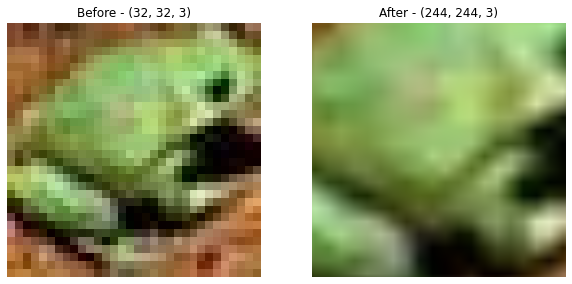

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image, label = next(sample_ds)
image_resized = resize(image, label)[0]
ax[0].imshow(image)
ax[0].axis("off")
ax[0].set_title(f"Before - {image.shape}")
ax[1].imshow(image_resized / 255)
ax[1].axis("off")
ax[1].set_title(f"After - {image_resized.shape}");

## 데이터 증강 정의
- 훈련을 개선하는 쉬운 방법은 훈련 알고리즘이 더 잘 일반화되도록 이미지를 무작위로 늘리는 것입니다. 선택할 수 있는 증강은 많지만 증강 기능을 더 많이 추가할수록 훈련을 위해 GPU로 이미지를 보내기 전에 더 많은 처리가 필요하다는 점을 명심하십시오. 
- 또한 이미지에 대한 예측을 있는 그대로 생성하기를 원하기 때문에 검증 데이터를 증강할 필요가 없다는 점에 유의하는 것이 중요합니다.

In [11]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_hue(image, 0.1)
    return (image, label)

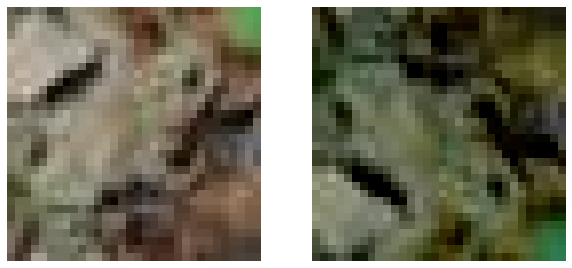

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image, label = next(sample_ds)
image_aug = augment(image, label)[0]
ax[0].imshow(image)
ax[0].axis("off")
ax[1].imshow(image_aug)
ax[1].axis("off");

# 3. 데이터세트에 변환 (Resize, Augmentation) 적용
- 훈련 데이터 세트에는 크기 조정 및 증대 기능이 적용되지만 검증 데이터 세트는 훈련에 직접 사용되지 않기 때문에 크기만 조정됩니다. 
- 각 레코드에 변환을 적용하기 위해 `.map()` 메서드를 호출할 때. 그러나 실제로는 아직 이미지를 변환하지 않습니다. 대신 훈련을 위해 GPU로 전송되기 직전에 CPU에 의해 변환이 완전히 적용됩니다. 이것은 모든 이미지가 변환될 때까지 기다릴 필요 없이 빠르게 실험할 수 있기 때문에 좋습니다.


- 변환을 무작위로 적용하는 이유가 궁금할 것입니다. 이는 훈련 알고리즘이 에포크의 데이터를 순환하기 때문에 수행됩니다.
    - 매 에포크마다 이미지를 다시 볼 수 있는 기회가 생기므로 매번 동일한 이미지를 전송하는 대신 무작위 증강을 적용합니다. 
    - 이상적으로는 알고리즘이 매 에포크마다 이미지의 모든 버전을 보도록 하겠지만, 이렇게 하면 훈련 데이터 세트의 크기가 증강 수만큼 확장됩니다. 해당 요인에 따라 데이터 스토리지 및 훈련 시간을 확장하는 것은 크게 가치가 없습니다.

In [13]:
train_ds = image_folder.as_dataset(split=["train"], shuffle_files=True, as_supervised=True)[0]
train_ds = train_ds.map(resize).map(augment)

<a id='idg3c.4'></a>
## 변환 시각화
___
모든 것이 제대로 작동하는지 확인하기 위해 몇 가지 이미지에 변형을 적용하고 확인을 합니다. 새로운 이미지 배치를 보려면 셀을 다시 실행하기만 하면 됩니다.

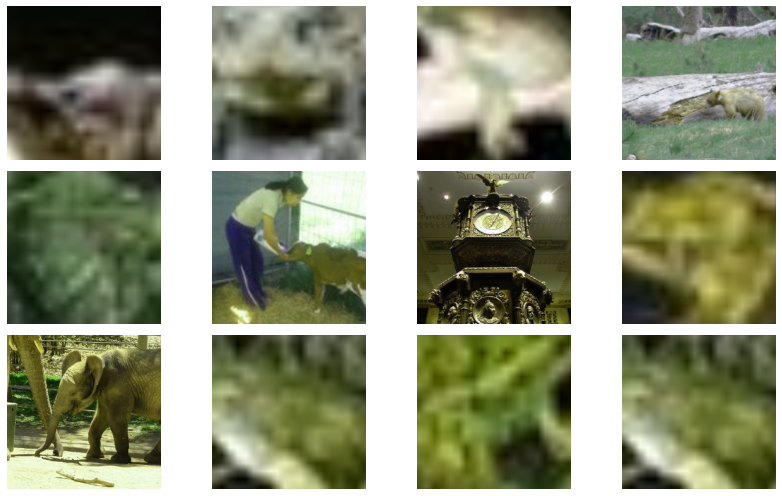

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(12, 7))

for ax in axs.flatten():
    sample = next(iter(train_ds))
    ax.imshow(tf.cast(sample[0], dtype=tf.uint8))
    ax.axis("off")

plt.tight_layout()

# 4. 데이터세트를 TFRecord 형식으로 저장
___
- TensorFlow에는 이미지 데이터를 훨씬 쉽게 이동하고 학습할 수 있는 자체 레코드 형식이 있습니다. 형식은 TFRecord라고 하며 기본적으로 수천 개의 개별 파일보다 읽기 프로세스가 훨씬 쉬운 하나 이상의 바이너리 청크로 이미지 데이터를 변환합니다. 
- TFRecord 형식의 한 가지 단점은 저장하는 이미지가 압축되지 않기 때문에 큰 jpeg 이미지가 있는 경우 파일 크기가 커질 수 있다는 것입니다. 한 가지 해결책은 TFRecord의 내장 압축을 사용하는 것이지만 훈련 중에 파일 압축을 풀어야 훈련 속도가 느려질 수 있습니다. 
- 여기에서 구현할 솔루션은 압축되지 않은 이미지 크기가 훨씬 작아지도록 TFRecord로 변환하기 전에 크기 조정 변환을 수행하는 것입니다.

#### 참고
- [TFRecord and tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord)

### helper fuctions 정의

In [15]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _image_as_bytes_feature(image):
    """Returns a bytes_list from an image tensor."""

    if image.dtype != tf.uint8:
        # `tf.io.encode_jpeg``requires tf.unit8 input images, with values between
        # 0 and 255. We do the conversion with the following function, if needed:
        image = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)

    # We convert the image tensor back into a byte list...
    image_string = tf.io.encode_jpeg(image, quality=90)

    # ... and then into a Feature:
    return _bytes_feature(image_string)


def image_example(image_tensor, label):
    image_shape = image_tensor.shape

    feature = {
        "height": _int64_feature(image_shape[0]),
        "width": _int64_feature(image_shape[1]),
        "depth": _int64_feature(image_shape[2]),
        "label": _int64_feature(label),
        "image_raw": _image_as_bytes_feature(image_tensor),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

### resize and rescale 변환 정의

In [16]:
def resize_rescale(image, label):
    image = tf.image.resize(image, (400, 400), preserve_aspect_ratio=True)
    image = tf.image.resize_with_crop_or_pad(image, 244, 244)
    image = image / 255.0
    return (image, label)

### TFRecord 를 위한 폴더 생성

In [17]:
import os
import shutil

tfrecord_dir = pathlib.Path("./data_tfrecord")

## 기존 폴더 있으면 삭제
if os.path.isdir(tfrecord_dir):
    shutil.rmtree(tfrecord_dir)
    print(f"{tfrecord_dir} is deleted")

tfrecord_dir.mkdir(exist_ok=True) # 폴더 생성

data_tfrecord is deleted


### train, val, test 에 대한 TFRecord 생성
아래 셀은 다음과 같은 과정을 통해서 진행 됩니다.
- tensorflow dataset 생성
- resize_rescale() 함수 매핑
- tf_example (height, width, depth, label, image_raw) 생성
- TFRecord 파일에 쓰기

In [18]:
train_ds = image_folder.as_dataset(split=["train"], shuffle_files=True, as_supervised=True)[0]
val_ds = image_folder.as_dataset(split=["val"], shuffle_files=True, as_supervised=True)[0]
test_ds = image_folder.as_dataset(split=["test"], shuffle_files=True, as_supervised=True)[0]

train_ds = train_ds.map(resize_rescale)
val_ds = val_ds.map(resize_rescale)
test_ds = test_ds.map(resize_rescale)

for name, data_split in zip(["train", "val", "test"], [train_ds, val_ds, test_ds]):
    record_file = f"data_tfrecord/{name}.tfrecord"
    with tf.io.TFRecordWriter(record_file) as writer:
        for image_tensor, label in tqdm(data_split):
            tf_example = image_example(image_tensor, label)
            writer.write(tf_example.SerializeToString())

100%|██████████| 275/275 [00:01<00:00, 230.43it/s]


# 5. S3 에 TFRecord 파일 업로드
___

In [19]:
import sagemaker

bucket_name = sagemaker.Session().default_bucket()
print("bucket name: ", bucket_name)

bucket name:  sagemaker-ap-northeast-2-057716757052


In [20]:
tensorflow_prefix = 'data-prep-workshop/tensorflow'

### Upload .tfrecord files

In [21]:
s3_uploader = sagemaker.s3.S3Uploader()

train_s3_uri = f's3://{bucket_name}/{tensorflow_prefix}/data/train'    
data_path = f"data_tfrecord/train.tfrecord"
train_tf_s3_uri = s3_uploader.upload(
    local_path=data_path, desired_s3_uri=train_s3_uri
)
print("train_tf_s3_uri: \n", train_tf_s3_uri)

train_tf_s3_uri: 
 s3://sagemaker-ap-northeast-2-057716757052/data-prep-workshop/tensorflow/data/train/train.tfrecord


In [22]:
val_s3_uri = f's3://{bucket_name}/{tensorflow_prefix}/data/val'    
data_path = f"data_tfrecord/val.tfrecord"
val_tf_s3_uri = s3_uploader.upload(
    local_path=data_path, desired_s3_uri=val_s3_uri
)
print("val_tf_s3_uri: \n", val_tf_s3_uri)

val_tf_s3_uri: 
 s3://sagemaker-ap-northeast-2-057716757052/data-prep-workshop/tensorflow/data/val/val.tfrecord


## 데이터 확인

In [23]:
! aws s3 ls {train_tf_s3_uri} --recursive
! aws s3 ls {val_tf_s3_uri} --recursive

2022-01-04 01:11:04   50526031 data-prep-workshop/tensorflow/data/train/train.tfrecord
2022-01-04 01:11:05    6541817 data-prep-workshop/tensorflow/data/val/val.tfrecord


## 다음 노트북에서 사용할 변수 저장
- 아래는 다음 노트북에서 변수를 사용하기 위해 저장 합니다.

In [24]:
%store bucket_name
%store train_tf_s3_uri
%store val_tf_s3_uri

Stored 'bucket_name' (str)
Stored 'train_tf_s3_uri' (str)
Stored 'val_tf_s3_uri' (str)


## 다음 단계
훈련 및 검증 데이터 세트가 S3에 저장되었으므로 TensorFlow 프레임워크용 SageMaker Estimator를 생성하고 원격 EC2 인스턴스에서 훈련 알고리즘을 실행할 수 있습니다.